ARABIC SIGN LANGUAGE DATASET - EXPLORATION

Total Classes: 20
Classes: ['baby', 'eat', 'father', 'finish', 'good', 'happy', 'hear', 'house', 'important', 'love', 'mall', 'me', 'mosque', 'mother', 'normal', 'sad', 'stop', 'thanks', 'thinking', 'worry']

Class: baby            | Videos: 430
Class: eat             | Videos: 440
Class: father          | Videos: 452
Class: finish          | Videos: 440
Class: good            | Videos: 436
Class: happy           | Videos: 445
Class: hear            | Videos: 433
Class: house           | Videos: 421
Class: important       | Videos: 446
Class: love            | Videos: 435
Class: mall            | Videos: 414
Class: me              | Videos: 430
Class: mosque          | Videos: 427
Class: mother          | Videos: 406
Class: normal          | Videos: 410
Class: sad             | Videos: 420
Class: stop            | Videos: 426
Class: thanks          | Videos: 412
Class: thinking        | Videos: 366
Class: worry           | Videos: 349


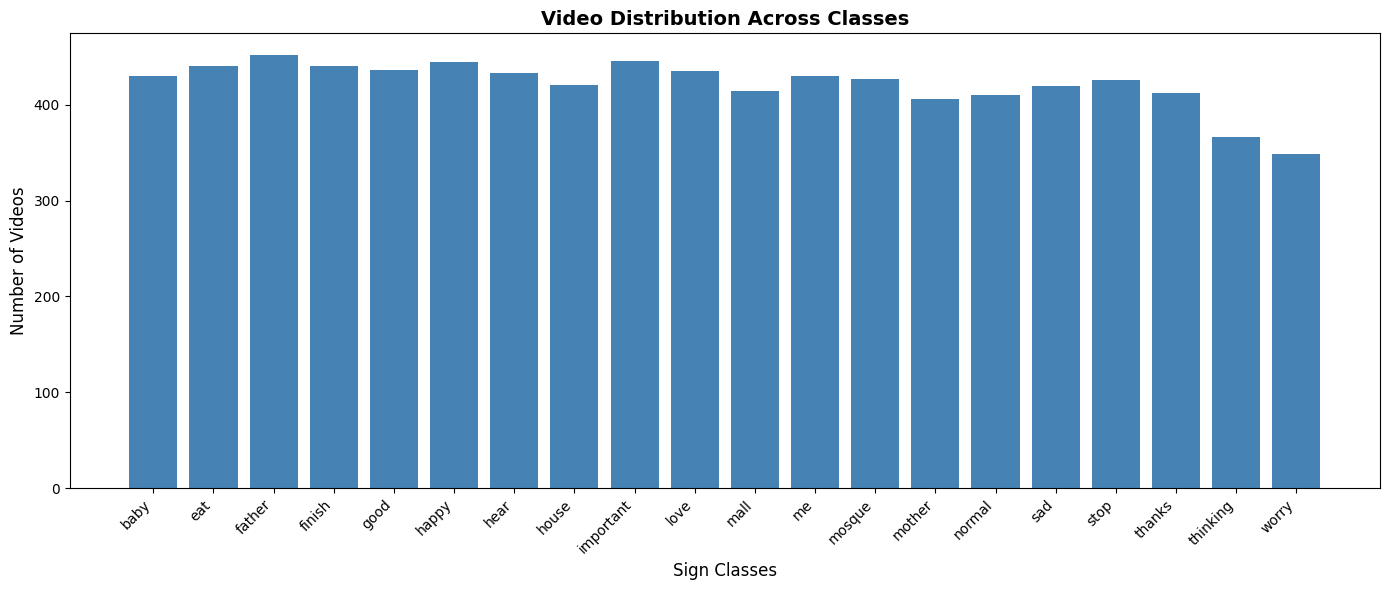


VIDEO SAMPLES ANALYSIS

Video Statistics (Sample):
 Class  Frames  FPS  Width  Height  Duration (s)
  baby      79   29    720    1280      2.724138
   eat      80   29   1088    1920      2.758621
father      74   29   1088    1920      2.551724
finish      78   29   1088    1920      2.689655
  good      68   30    720    1280      2.266667

FEATURE EXTRACTION WITH MEDIAPIPE
Extracting features from videos...


Processing classes: 100%|██████████| 20/20 [55:53<00:00, 167.70s/it]



Features shape: (1000, 30, 63)
Labels shape: (1000,)

Saving extracted features...
Features saved: X_features.npy, y_labels.npy
Training samples: 800
Validation samples: 200

MODEL BUILDING: ResNet50 + LSTM
Using device: cuda


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [1]:
import sys
import subprocess

# subprocess.check_call([sys.executable, "-m", "pip", "install", "mediapipe", "-q"])

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mediapipe as mp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_PATH = '../data/compressed videos'

print("=" * 80)
print("ARABIC SIGN LANGUAGE DATASET - EXPLORATION")
print("=" * 80)

class_folders = [d for d in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, d))]
class_folders.sort()

print(f"\nTotal Classes: {len(class_folders)}")
print(f"Classes: {class_folders}\n")

data_info = []
for class_name in class_folders:
    class_path = os.path.join(BASE_PATH, class_name)
    videos = [f for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    data_info.append({
        'Class': class_name,
        'Video Count': len(videos),
        'Path': class_path
    })
    print(f"Class: {class_name:15s} | Videos: {len(videos):3d}")

df_info = pd.DataFrame(data_info)

plt.figure(figsize=(14, 6))
plt.bar(df_info['Class'], df_info['Video Count'], color='steelblue')
plt.xlabel('Sign Classes', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Video Distribution Across Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("VIDEO SAMPLES ANALYSIS")
print("=" * 80)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

video_stats = []
for idx, row in df_info.head(5).iterrows():
    class_path = row['Path']
    videos = [f for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    
    if videos:
        video_path = os.path.join(class_path, videos[0])
        cap = cv2.VideoCapture(video_path)
        
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = frame_count / fps if fps > 0 else 0
        
        video_stats.append({
            'Class': row['Class'],
            'Frames': frame_count,
            'FPS': fps,
            'Width': width,
            'Height': height,
            'Duration (s)': duration
        })
        
        cap.release()

df_stats = pd.DataFrame(video_stats)
print("\nVideo Statistics (Sample):")
print(df_stats.to_string(index=False))

print("\n" + "=" * 80)
print("FEATURE EXTRACTION WITH MEDIAPIPE")
print("=" * 80)

def extract_features_from_video(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    features = []
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, frame_count - 1, max_frames, dtype=int)
    
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            landmarks = []
            for landmark in hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
            features.append(landmarks)
        else:
            features.append([0] * 63)
    
    cap.release()
    
    while len(features) < max_frames:
        features.append([0] * 63)
    
    return np.array(features[:max_frames])

print("Extracting features from videos...")

X_data = []
y_data = []

for class_name in tqdm(class_folders, desc="Processing classes"):
    class_path = os.path.join(BASE_PATH, class_name)
    videos = [f for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    
    for video in videos[:50]:
        video_path = os.path.join(class_path, video)
        features = extract_features_from_video(video_path)
        X_data.append(features)
        y_data.append(class_name)

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"\nFeatures shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")

# Save extracted features
print("\nSaving extracted features...")
np.save('X_features.npy', X_data)
np.save('y_labels.npy', y_data)
print("Features saved: X_features.npy, y_labels.npy")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

np.save('label_encoder_classes.npy', label_encoder.classes_)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

print("\n" + "=" * 80)
print("MODEL BUILDING: ResNet50 + LSTM")
print("=" * 80)

class SignLanguageDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = SignLanguageDataset(X_train, y_train)
val_dataset = SignLanguageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class ResNetLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=2):
        super(ResNetLSTM, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(63, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3)
        )
        
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        
        x = x.view(batch_size * seq_len, features)
        x = self.feature_extractor(x)
        x = x.view(batch_size, seq_len, -1)
        
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(label_encoder.classes_)
model = ResNetLSTM(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

print("\n" + "=" * 80)
print("TRAINING MODEL")
print("=" * 80)

num_epochs = 80  # Changed from 50 to 80
best_accuracy = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    scheduler.step(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
            'num_classes': num_classes
        }, 'best_sign_language_model.pth')
        print(f"Model saved with accuracy: {accuracy:.2f}%")

print("\n" + "=" * 80)
print(f"TRAINING COMPLETED - Best Accuracy: {best_accuracy:.2f}%")
print("=" * 80)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Test Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel and features saved successfully!")
print("Files created:")
print("  - best_sign_language_model.pth")
print("  - label_encoder_classes.npy")
print("  - X_features.npy")
print("  - y_labels.npy")

LOADING EXTRACTED FEATURES
Features shape: (1000, 30, 63)
Labels shape: (1000,)
Number of classes: 20
Training samples: 800
Validation samples: 200

Using device: cuda

TRAINING MODEL - 50 EPOCHS
Epoch [1/50] | Loss: 2.9413 | Val Accuracy: 7.00%
Model saved with validation accuracy: 7.00%
Epoch [2/50] | Loss: 2.7346 | Val Accuracy: 12.00%
Model saved with validation accuracy: 12.00%
Epoch [3/50] | Loss: 2.6128 | Val Accuracy: 13.00%
Model saved with validation accuracy: 13.00%
Epoch [4/50] | Loss: 2.5412 | Val Accuracy: 18.00%
Model saved with validation accuracy: 18.00%
Epoch [5/50] | Loss: 2.3200 | Val Accuracy: 27.00%
Model saved with validation accuracy: 27.00%
Epoch [6/50] | Loss: 2.1902 | Val Accuracy: 35.50%
Model saved with validation accuracy: 35.50%
Epoch [7/50] | Loss: 1.9259 | Val Accuracy: 37.50%
Model saved with validation accuracy: 37.50%
Epoch [8/50] | Loss: 1.7753 | Val Accuracy: 39.50%
Model saved with validation accuracy: 39.50%
Epoch [9/50] | Loss: 1.7616 | Val Accu

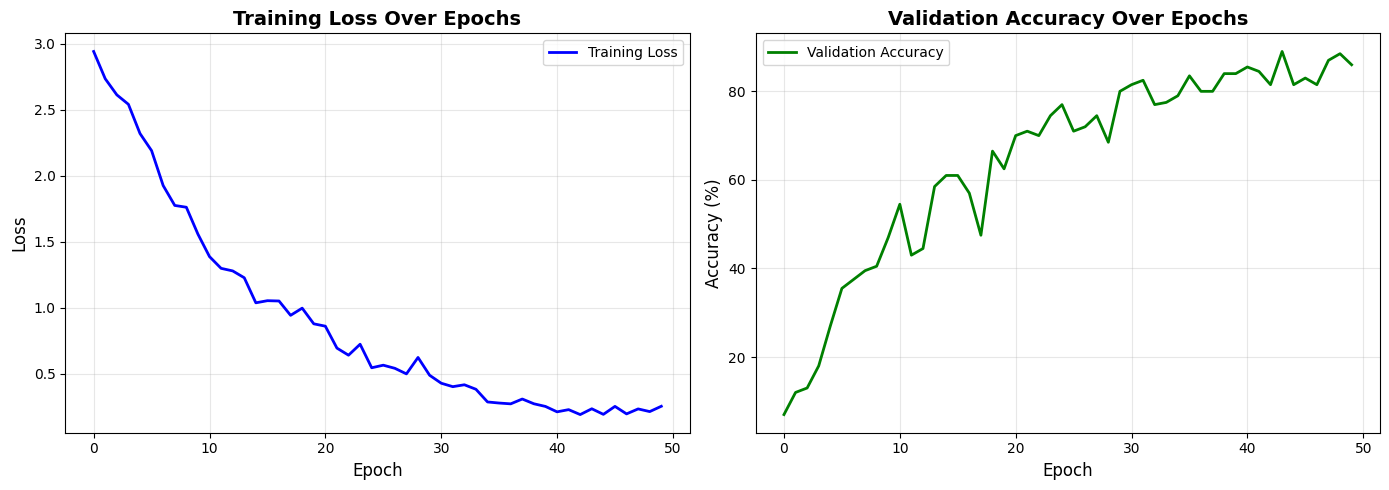


Training completed successfully!
Files created:
  - best_sign_language_model_50epochs.pth
  - training_metrics_50epochs.png


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
OUTPUT_DIR = "../output/features"
print("=" * 80)
print("LOADING EXTRACTED FEATURES")
print("=" * 80)

X_data = np.load(os.path.join(OUTPUT_DIR, 'X_features.npy'))
y_data = np.load(os.path.join(OUTPUT_DIR, 'y_labels.npy'))
label_encoder_classes = np.load(os.path.join(OUTPUT_DIR, 'label_encoder_classes.npy'))

print(f"Features shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")
print(f"Number of classes: {len(label_encoder_classes)}")

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes
y_encoded = label_encoder.transform(y_data)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

class SignLanguageDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = SignLanguageDataset(X_train, y_train)
val_dataset = SignLanguageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class ResNetLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=2):
        super(ResNetLSTM, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(63, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3)
        )
        
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        
        x = x.view(batch_size * seq_len, features)
        x = self.feature_extractor(x)
        x = x.view(batch_size, seq_len, -1)
        
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

num_classes = len(label_encoder_classes)
model = ResNetLSTM(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print("\n" + "=" * 80)
print("TRAINING MODEL - 50 EPOCHS")
print("=" * 80)

num_epochs = 50
best_accuracy = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    scheduler.step(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Accuracy: {accuracy:.2f}%")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
            'num_classes': num_classes
        }, 'best_sign_language_model_500epochs.pth')
        print(f"Model saved with validation accuracy: {accuracy:.2f}%")

print("\n" + "=" * 80)
print(f"TRAINING COMPLETED - Best Validation Accuracy: {best_accuracy:.2f}%")
print("=" * 80)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics_500epochs.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining completed successfully!")
print("Files created:")
print("  - best_sign_language_model_50epochs.pth")
print("  - training_metrics_50epochs.png")

LOADING EXTRACTED FEATURES
Features shape: (1000, 30, 63)
Labels shape: (1000,)
Number of classes: 20
Training samples: 800
Validation samples: 200

Using device: cuda

TRAINING ENHANCED MODEL - 500 EPOCHS
Epoch [1/500] | Loss: 2.7892 | Val Accuracy: 6.00% | LR: 0.000976
✓ Model saved with validation accuracy: 6.00%
Epoch [2/500] | Loss: 2.2395 | Val Accuracy: 24.50% | LR: 0.000905
✓ Model saved with validation accuracy: 24.50%
Epoch [3/500] | Loss: 1.9393 | Val Accuracy: 46.00% | LR: 0.000794
✓ Model saved with validation accuracy: 46.00%
Epoch [4/500] | Loss: 1.6957 | Val Accuracy: 65.00% | LR: 0.000655
✓ Model saved with validation accuracy: 65.00%
Epoch [5/500] | Loss: 1.4250 | Val Accuracy: 71.50% | LR: 0.000501
✓ Model saved with validation accuracy: 71.50%
Epoch [6/500] | Loss: 1.2716 | Val Accuracy: 73.00% | LR: 0.000346
✓ Model saved with validation accuracy: 73.00%
Epoch [7/500] | Loss: 1.1201 | Val Accuracy: 85.00% | LR: 0.000207
✓ Model saved with validation accuracy: 85.00

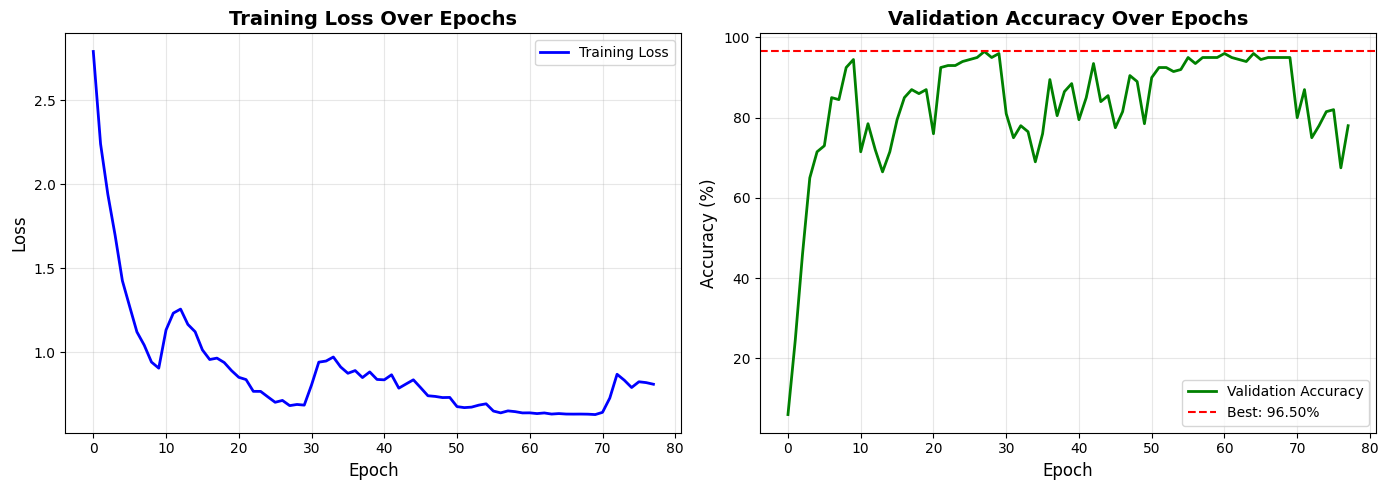


Training completed successfully!
Files created:
  - best_enhanced_model.pth
  - enhanced_training_metrics.png


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("LOADING EXTRACTED FEATURES")
print("=" * 80)

X_data = np.load('X_features.npy')
y_data = np.load('y_labels.npy')
label_encoder_classes = np.load('label_encoder_classes.npy')

print(f"Features shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")
print(f"Number of classes: {len(label_encoder_classes)}")

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes
y_encoded = label_encoder.transform(y_data)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

class SignLanguageDataset(Dataset):
    def __init__(self, features, labels, augment=False):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.augment = augment
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        
        if self.augment:
            if torch.rand(1) > 0.5:
                noise = torch.randn_like(x) * 0.01
                x = x + noise
            
            if torch.rand(1) > 0.5:
                x = x * torch.FloatTensor([1.0]).uniform_(0.95, 1.05)
            
            if torch.rand(1) > 0.7:
                time_shift = torch.randint(-2, 3, (1,)).item()
                if time_shift != 0:
                    x = torch.roll(x, time_shift, dims=0)
        
        return x, self.labels[idx]

train_dataset = SignLanguageDataset(X_train, y_train, augment=True)
val_dataset = SignLanguageDataset(X_val, y_val, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

class AttentionBlock(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, lstm_output):
        attention_weights = self.attention(lstm_output)
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted_output = torch.sum(attention_weights * lstm_output, dim=1)
        return weighted_output

class EnhancedResNetLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=512, num_layers=3):
        super(EnhancedResNetLSTM, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(63, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3)
        )
        
        self.lstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True, dropout=0.4, bidirectional=True)
        
        self.attention = AttentionBlock(hidden_size * 2)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        
        x = x.view(batch_size * seq_len, features)
        x = self.feature_extractor(x)
        x = x.view(batch_size, seq_len, -1)
        
        lstm_out, _ = self.lstm(x)
        
        x = self.attention(lstm_out)
        
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

num_classes = len(label_encoder_classes)
model = EnhancedResNetLSTM(num_classes=num_classes).to(device)

class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

print("\n" + "=" * 80)
print("TRAINING ENHANCED MODEL - 500 EPOCHS")
print("=" * 80)

num_epochs = 500
best_accuracy = 0.0
train_losses = []
val_accuracies = []
patience_counter = 0
patience_limit = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Accuracy: {accuracy:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
            'num_classes': num_classes
        }, 'best_enhanced_model.pth')
        print(f"✓ Model saved with validation accuracy: {accuracy:.2f}%")
    else:
        patience_counter += 1
    
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n" + "=" * 80)
print(f"TRAINING COMPLETED - Best Validation Accuracy: {best_accuracy:.2f}%")
print("=" * 80)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
plt.axhline(y=best_accuracy, color='r', linestyle='--', label=f'Best: {best_accuracy:.2f}%')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining completed successfully!")
print("Files created:")
print("  - best_enhanced_model.pth")
print("  - enhanced_training_metrics.png")